In [1]:
!pip install -U bitsandbytes
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 24.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 8.7 MB/s eta 0:00:00:00:01


In [2]:
!pip install -q datasets==2.13.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
pathos 0.3.3 requires dill>=0.3.9, but you have dill 0.3.6 which is incompatible.
pathos 0.3.3 requires multiprocess>=0.70.17, but you have multiprocess 0.70.14 which is incompatible.


In [3]:
import pandas as pd
from datasets import load_dataset 
import transformers
from transformers import BlipProcessor, BlipForImageTextRetrieval,BlipForConditionalGeneration, AutoProcessor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests
from matplotlib import pyplot as plt


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('/kaggle/input/roco-dataset/all_data/train/radiology/traindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = 'radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [5]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

,id,name,caption
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ..."
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ..."
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...


In [6]:
df_train['images'] = "radiology/images/" + df_train['name']
df_train.head()

,id,name,caption,images
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...,radiology/images/PMC4083729_AMHSR-4-14-g002.jpg
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...,radiology/images/PMC2837471_IJD2009-150251.001...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...,radiology/images/PMC2505281_11999_2007_30_Fig6...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n,radiology/images/PMC3745845_IJD2013-683423.005...
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...,radiology/images/PMC4917066_amjcaserep-17-301-...


In [7]:
df_train['images'] = "radiology/images/" + df_train['name']
df_train.head()

,id,name,caption,images
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...,radiology/images/PMC4083729_AMHSR-4-14-g002.jpg
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...,radiology/images/PMC2837471_IJD2009-150251.001...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...,radiology/images/PMC2505281_11999_2007_30_Fig6...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n,radiology/images/PMC3745845_IJD2013-683423.005...
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...,radiology/images/PMC4917066_amjcaserep-17-301-...


In [8]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

,id,name,caption,images
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",radiology/images/PMC5144533_IJCCM-20-677-g002.jpg
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,radiology/images/PMC4863054_ir-14-187-g002.jpg
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",radiology/images/PMC4093973_IJCIIS-4-186-g001.jpg
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,radiology/images/PMC5616218_cureus-0009-000000...
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...,radiology/images/PMC5018069_gr1.jpg


In [9]:
# Create "images" column to create full path for images
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']
filtered_df.head()

/tmp/ipykernel_30/1067852196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']


,id,name,caption,images
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",/kaggle/input/roco-dataset/all_data/train/radi...
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,/kaggle/input/roco-dataset/all_data/train/radi...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",/kaggle/input/roco-dataset/all_data/train/radi...
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,/kaggle/input/roco-dataset/all_data/train/radi...
307,ROCO_00383,PMC5018069_gr1.jpg,Chest X-ray on the day of admission showing d...,/kaggle/input/roco-dataset/all_data/train/radi...


In [10]:
from datasets import Dataset
from PIL import Image, UnidentifiedImageError
import pandas as pd
import os
# Define a function to load the image based on the file path if it exists and is valid
def load_image(file_path):
    if os.path.exists(file_path):
        try:
            return Image.open(file_path)
        except UnidentifiedImageError:
            print(f"Unidentified image file: {file_path}")  # Log the error for tracking
            return None
    else:
        print(f"File not found: {file_path}")  # Log the missing file
        return None  # Return None if the image doesn't exist or can't be opened

# Filter the dataset to include only existing and valid images
images = []
captions = []
for image_path, caption in zip(filtered_df['images'], filtered_df['caption']):
    image = load_image(image_path)
    if image is not None:
        images.append(image)
        captions.append(caption)

# Prepare data dictionary for the Hugging Face Dataset
data = {
    'image': images,
    'text': captions
}

# Create the Hugging Face Dataset
dataset = Dataset.from_dict(data)

# Display dataset summary
print(dataset)


Dataset({
    features: ['image', 'text'],
    num_rows: 1735
})


In [11]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding
def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch



In [12]:
import ipywidgets as widgets
widgets.Widget.widget_types = {}


In [13]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)
     

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [14]:

from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


In [15]:

# Create the train dataset and dataloader
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)


In [16]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(1):
    print("Epoch:", epoch)
    
    epoch_loss = 0.0  # Initialize epoch loss
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, dtype=torch.float16)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        
        loss = outputs.loss
        
        epoch_loss += loss.item()  # Accumulate loss for the epoch

        # Backpropagation
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    # Print epoch loss after finishing all batches in the epoch
    print("Epoch Loss:", epoch_loss)


Epoch: 0


Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


Epoch Loss: 366.08935546875


In [17]:
# Define the path where you want to save the model
save_path = "/kaggle/working/trained_model_captcha_generation1.pth"
# Save the model's state dictionary
torch.save(model.state_dict(), save_path)
print(f"Model saved successfully at {save_path}")


Model saved successfully at /kaggle/working/trained_model_captcha_generation1.pth


In [18]:
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
                (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
      

In [ ]:
# Define the path where the weights are stored
model_weights_path = "/kaggle/working/trained_model_captcha_generation1.pth"

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_weights_path, map_location=device))
print(f"Model loaded successfully from {model_weights_path}")

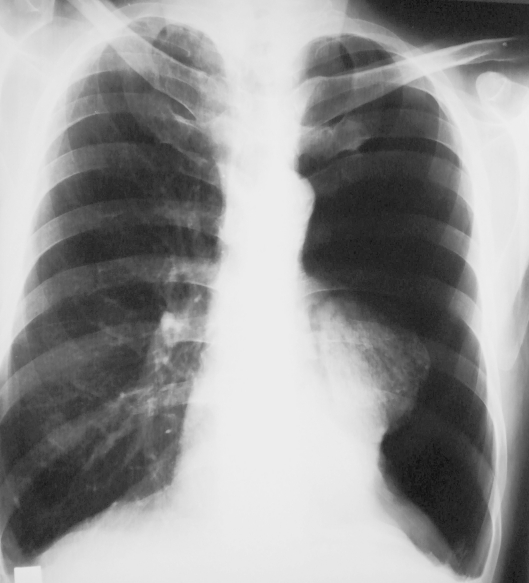

In [46]:

# load image
example = dataset[100]
image = example["image"]
image


In [47]:
text = example["text"]
text

' Chest x-ray showing an air density in left lung fields\n'

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

In [21]:
model_weights_path = "/kaggle/working/trained_model_captcha_generation1.pth"


In [ ]:
### Load the trained model
load_model = BlipForConditionalGeneration.from_pretrained(model_weights_path)
load_processor = AutoProcessor.from_pretrained(model_weights_path)

In [ ]:
model.load_state_dict(torch.load(model_weights_path))


In [ ]:
import shutil

# Path of the model file
model_path = "/kaggle/working/trained_model_captcha_generation1.pth"

# Path for the zipped file
zip_path = "/kaggle/working/trained_model_captcha_generation1.zip"

# Create a zip file
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', '/kaggle/working', 'trained_model_captcha_generation1.pth')

print(f"Model successfully zipped at {zip_path}")
